In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely import Polygon
from shapely import MultiPolygon
import h3.api.numpy_int as h3
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr

In [2]:
import pysal as ps

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
import spopt

In [4]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

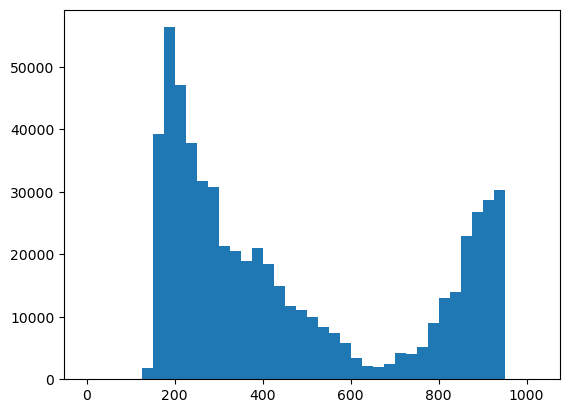

In [6]:
plt.hist(ob_pre[np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))],np.arange(0.,1026.,25.))
plt.show()

In [21]:
opt_tim=1.5 # select observations around this time (hrs) in the time-window (0==analysis-time)
opt_pre=225. # select observations around this pressure-level (hPa)
# Select subset of data from lat, lon, prs, tim: 
idx=np.where((ob_use==1.)&
             (np.abs(ob_pre-opt_pre)<25.)&
             (np.abs(ob_tim-opt_tim)<0.5)&
             (ob_typ>=240)&(ob_typ<=260)
            )[0]
print('{:d} observations in range'.format(np.size(idx)))
# Construct a geopandas point dataset 
point_list=[]
for i in idx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 'lat': list(ob_lat[idx]) , 'lon': list(ob_lon[idx]), 'ob_idx': list(idx)}
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")

3058 observations in range


In [22]:
# Let's get the uwd, vwd, and geopotential height (hgt) for opt_pre
grib_file=data_dir+'/gdas.t00z.pgrb2.0p25.anl'
grib=xr.load_dataset(grib_file,engine='cfgrib',filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
grib_levs=grib.variables['isobaricInhPa'].values
glev_idx=np.where(grib_levs==opt_pre)
grib_uwd=grib.variables['u'].values[glev_idx,:,:].squeeze()
grib_vwd=grib.variables['v'].values[glev_idx,:,:].squeeze()
grib_hgt=grib.variables['gh'].values[glev_idx,:,:].squeeze()

skipping variable: paramId==260018 shortName='clwmr'
Traceback (most recent call last):
  File "/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500

In [23]:
grib_lat=grib.variables['latitude'].values
grib_lon=grib.variables['longitude'].values
# For whatever reason, cartopy does not like grib_lon in (-180.,180.) format
fix=np.where(grib_lon<0.)
grib_lon[fix]=grib_lon[fix]+360.

In [24]:
# Assign obs to hexes of a chosen resolution hexgrid
def assign_h3(df, resolution):
    #df[f'h3_{resolution}'] = df.apply(lambda row: h3.h3_to_string(h3.geo_to_h3(row['lat'], row['lon'], resolution)), axis=1)
    df[f'h3_cell'] = df.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], resolution), axis=1)
res=4
assign_h3(gdf, res)

In [25]:
# Generate a list of all h3{res} cells not in gdf
h3r0hexes=h3.get_res0_indexes()
h3hexes=[]
for hx in h3r0hexes:
    h3hexes.extend(list(h3.h3_to_children(hx,res=res)))
h3all=np.asarray(h3hexes)
print('{:d} total hexes at res={:d}'.format(np.size(h3all),res))

h3Filled=np.unique(gdf['h3_cell'].values).astype(h3all.dtype)
print('{:d} filled hexes at res={:d}'.format(np.size(h3Filled),res))

#full=np.where(np.isin(h3all,np.unique(gdf['h3_cell'].values)))
full=np.where(np.isin(h3all,h3Filled))
empty=np.setdiff1d(np.arange(np.size(h3all)),full)
h3empty=h3all[empty]
print('{:d} empty hexes at res={:d}'.format(np.size(h3empty),res))

h3comp=h3.compact(h3empty)
print('{:d} compacted empty hexes at res<={:d}'.format(np.size(h3comp),res))

h3Mosaic=np.append(h3Filled,h3comp)
print('{:d} total compacted hexes at res<={:d}'.format(np.size(h3Mosaic),res))

288122 total hexes at res=4
2343 filled hexes at res=4
285779 empty hexes at res=4
16170 compacted empty hexes at res<=4
18513 total compacted hexes at res<=4


In [26]:
# Generate list of h3Filled polygons, and convert to a MultiPolygon
# NOTE: The use of h3.h3_set_to_multipolygon() implies I should be able to do this in one step,
#       but so far I just run into an endless revolving-door of errors.
h3MosaicPolys=[]
for hx in h3Mosaic:
    h3MosaicPolys.append(Polygon(h3.h3_set_to_multi_polygon([hx])[0][0]))
h3MosaicMultiPoly=MultiPolygon(h3MosaicPolys)

In [27]:
# Generate list of h3Filled polygons, and convert to a MultiPolygon
# NOTE: The use of h3.h3_set_to_multipolygon() implies I should be able to do this in one step,
#       but so far I just run into an endless revolving-door of errors.
h3FilledPolys=[]
for hx in h3Filled:
    h3FilledPolys.append(Polygon(h3.h3_set_to_multi_polygon([hx])[0][0]))
h3FilledMultiPoly=MultiPolygon(h3FilledPolys)

In [28]:
# Generate plots for h3FilledMultiPoly and h3MosaicMultiPoly
proj=ccrs.PlateCarree()
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

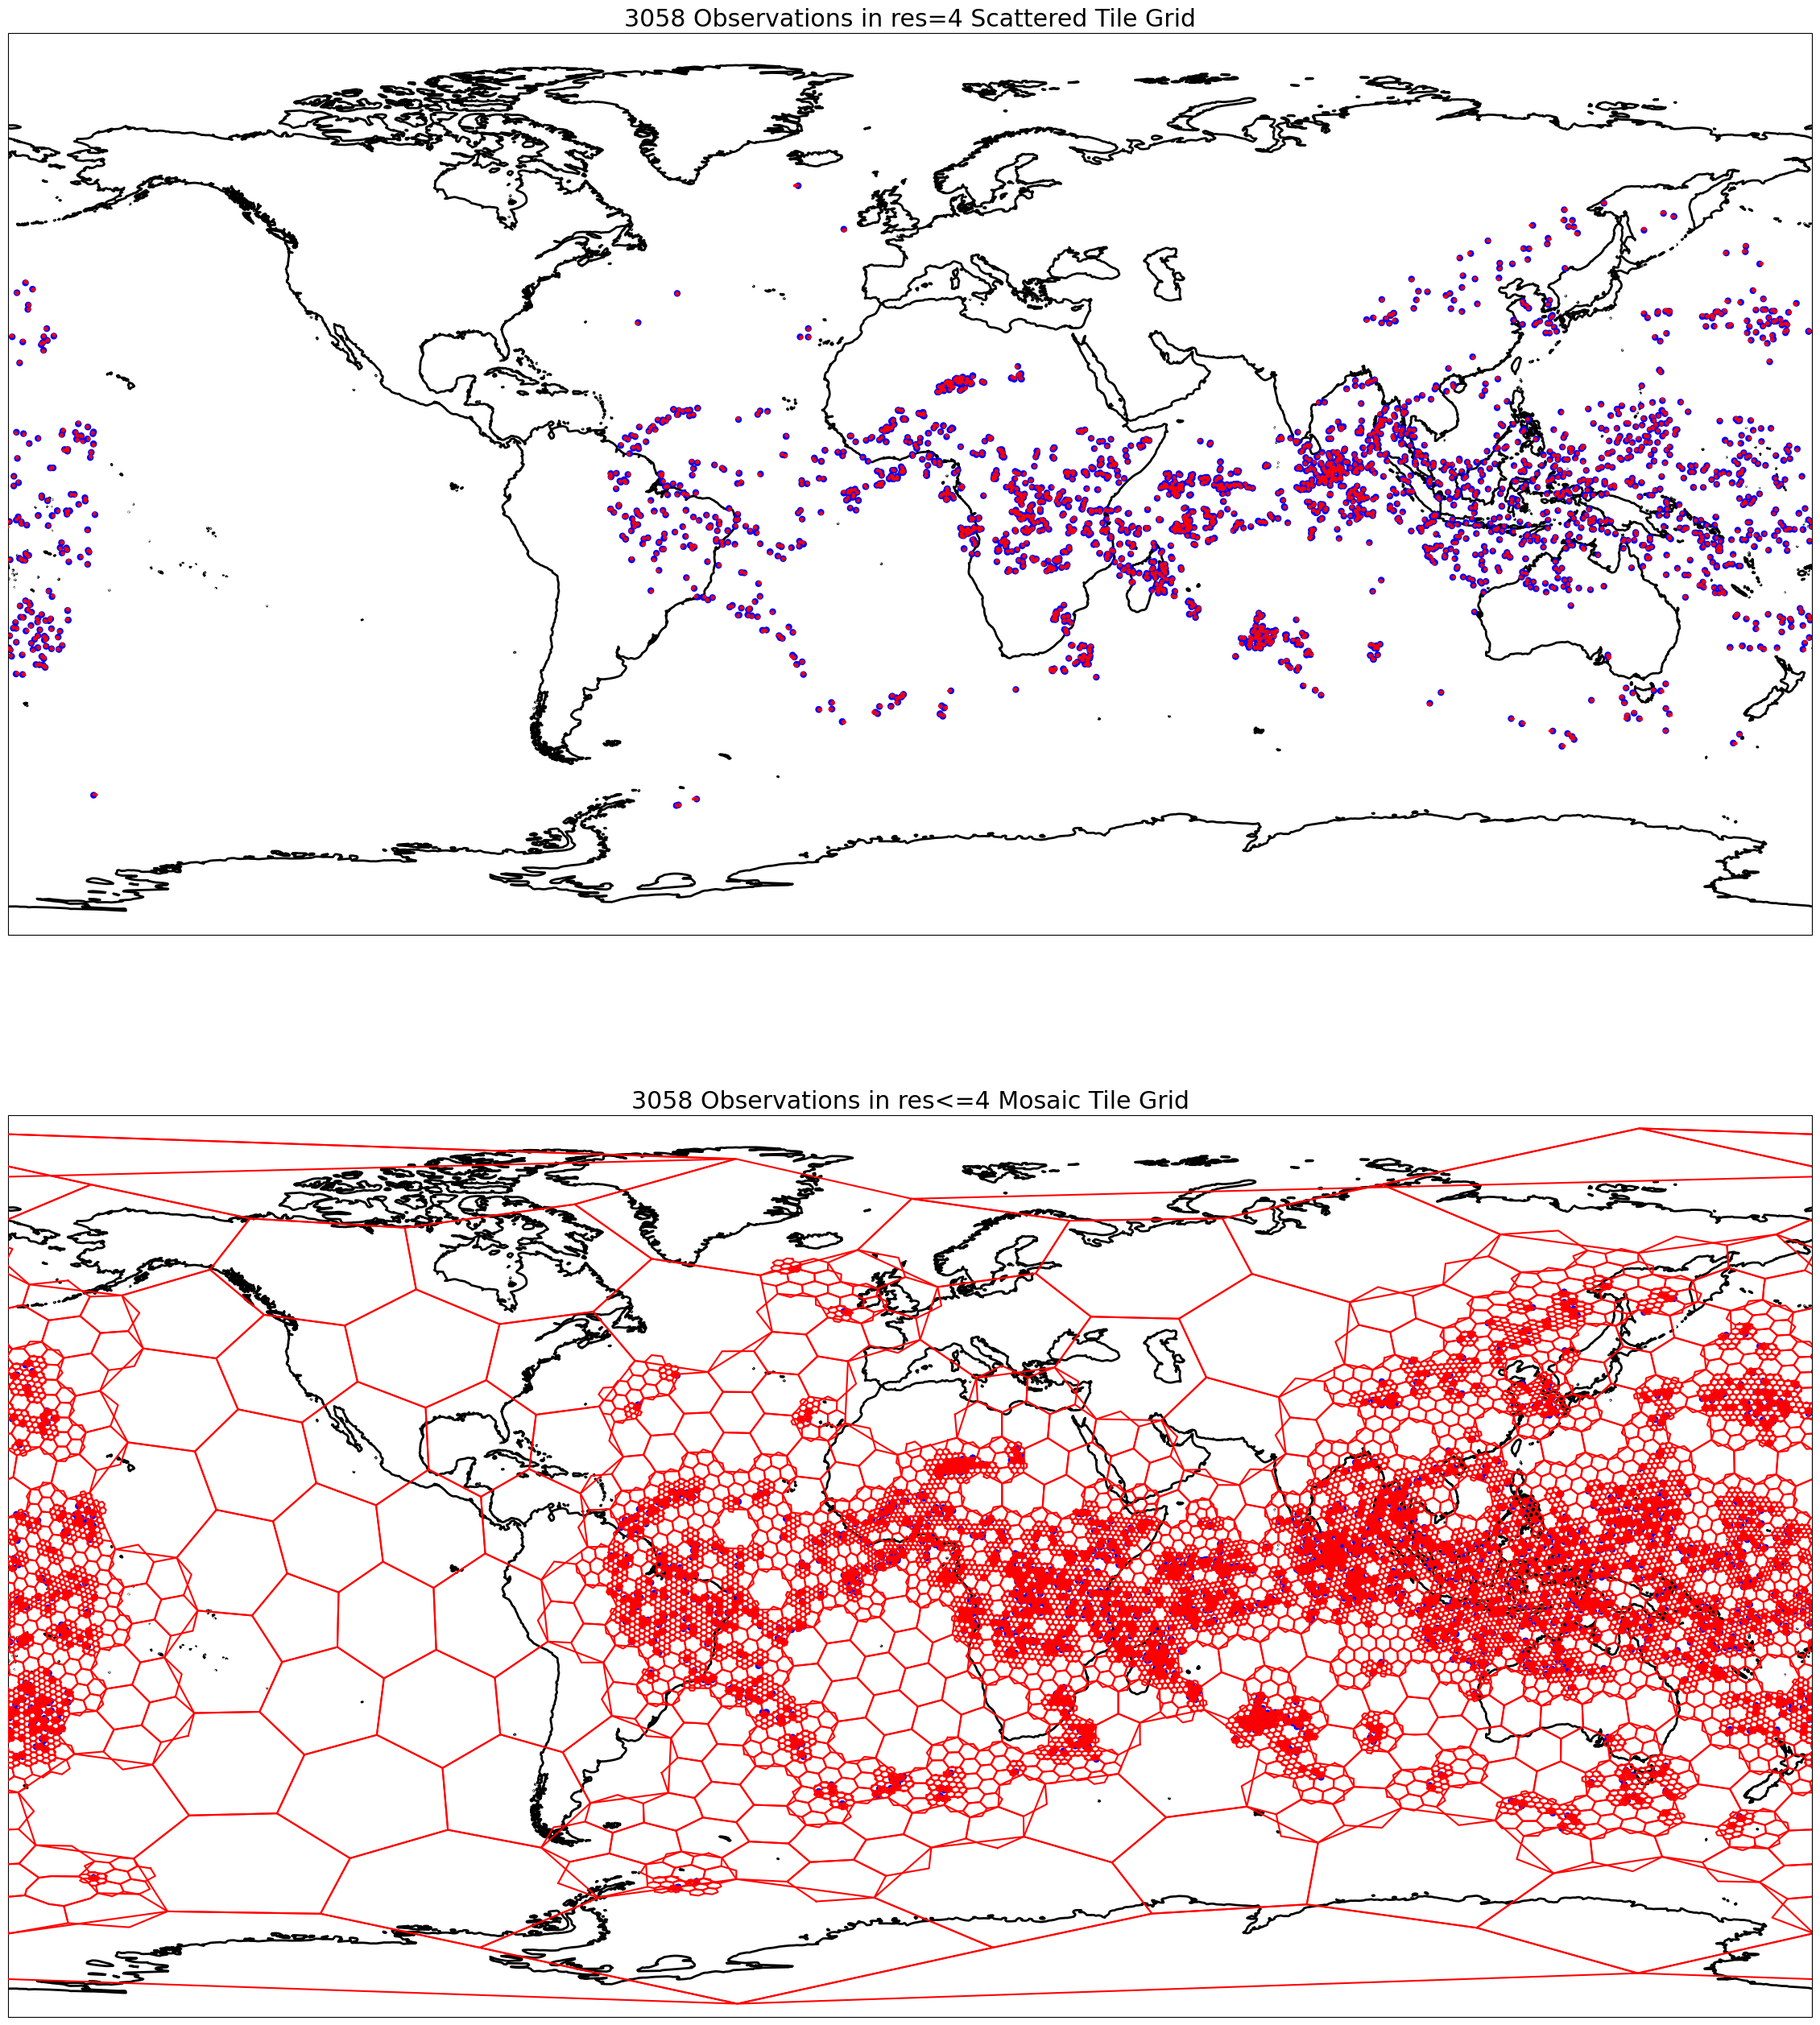

In [29]:
fig,(ax1,ax2)=plt.subplots( #.......................................................................... Figure handle with figure size
                   nrows=2,
                   ncols=1,
                   subplot_kw={'projection': proj},
                   figsize=(30,32)
                   )
ax1.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for geom in h3FilledMultiPoly.geoms:
    # Assert as numpy array from tuple
    polyg=np.asarray(geom.exterior.xy[::-1])
    # Fix: If the boundary crosses the 180/-180 meridian,
    #      extend the positive bound into <-180 longitude space
    #      (plotting doesn't appear to care here, otherwise it
    #       forces polygon to span the entire plot)
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    ax1.plot(*polyg,color='red',transform=proj,zorder=3)
# Plot obs data on top
sca=ax1.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           zorder=2
          )
ax1.set_global()
ax1.set_title('{:d} Observations in res={:d} Scattered Tile Grid'.format(np.size(idx),res))

ax2.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for geom in h3MosaicMultiPoly.geoms:
    # Assert as numpy array from tuple
    polyg=np.asarray(geom.exterior.xy[::-1])
    # Fix: If the boundary crosses the 180/-180 meridian,
    #      extend the positive bound into <-180 longitude space
    #      (plotting doesn't appear to care here, otherwise it
    #       forces polygon to span the entire plot)
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    ax2.plot(*polyg,color='red',transform=proj,zorder=3)
# Plot obs data on top
sca=ax2.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           zorder=2
          )
ax2.set_global()
ax2.set_title('{:d} Observations in res<={:d} Mosaic Tile Grid'.format(np.size(idx),res))

plt.show()

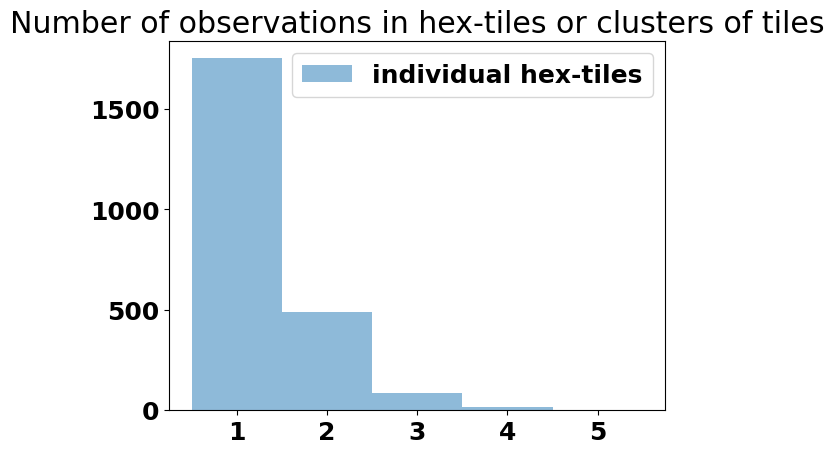

In [32]:
# Construct a geopandas dataframe with each unique h3 cell
d = {'geometry': h3FilledPolys,'h3_cell': np.unique(gdf['h3_cell'].values)}
n_obs=[]
n_typ=[]
u_mean=[]
v_mean=[]
u_stdv=[]
v_stdv=[]
p_mean=[]
p_stdv=[]
t_mean=[]
t_stdv=[]

for cell in d['h3_cell']:
    ids=gdf.loc[gdf['h3_cell']==cell]['ob_idx']
    n_obs.append(len(ids))
    u_mean.append(np.mean(ob_uwd[ids]))
    v_mean.append(np.mean(ob_vwd[ids]))
    p_mean.append(np.mean(ob_pre[ids]))
    t_mean.append(np.mean(ob_tim[ids]))
d['nobs']=n_obs
d['uavg']=u_mean
d['vavg']=v_mean
d['pavg']=p_mean
d['tavg']=t_mean
cellframe = gpd.GeoDataFrame(d, crs="EPSG:4326")
plt.hist(cellframe['nobs'].values,np.arange(0.5,max(cellframe['nobs'].values)+0.6,1.),alpha=0.5)
plt.legend(['individual hex-tiles'])
plt.title('Number of observations in hex-tiles or clusters of tiles')
plt.show()

In [33]:
cellframe.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  2343 non-null   geometry
 1   h3_cell   2343 non-null   int64   
 2   nobs      2343 non-null   int64   
 3   uavg      2343 non-null   float32 
 4   vavg      2343 non-null   float32 
 5   pavg      2343 non-null   float32 
 6   tavg      2343 non-null   float32 
dtypes: float32(4), geometry(1), int64(2)
memory usage: 91.7 KB


In [34]:
import libpysal
from spopt.region import MaxPHeuristic as MaxP
from libpysal.weights import higher_order

In [35]:
w = libpysal.weights.Rook.from_dataframe(cellframe) # Generates a lot of 'islands' warnings when applied to h3Filled, but not so much h3Mosaic
#w = libpysal.weights.Kernel.from_dataframe(cellframe,function='gaussian') # https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html
#w = libpysal.weights.Kernel.from_dataframe(cellframe,function='gaussian',k=7) # each hexagon has 7 neighboring hexes
# function='gaussian' connects tiles across large distances

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1618 disconnected components.
 There are 1204 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 79, 83, 84, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 101, 102, 103, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 124, 125, 126, 129, 130, 132, 135, 137, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 167, 168, 169, 171, 172, 173, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 207, 210, 213, 214, 215, 216, 217, 220, 221, 222, 225

In [36]:
# Let's try separating islands from the rest of the dataset
cellframe_islands=cellframe.iloc[w.islands]
cellframe_islands=cellframe_islands.reset_index() # Resets index numbering to start at 0
cellframe_connect=cellframe.drop(index=w.islands)
cellframe_connect=cellframe_connect.reset_index() # Resets index numbering to start at 0
w = libpysal.weights.Rook.from_dataframe(cellframe_connect)


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 414 disconnected components.
  warnings.warn(message)


In [37]:
w.islands

[]

In [38]:
attrs_name = [f"uavg" , f"vavg" , f"tavg"]
threshold_name = "nobs"
threshold = 2

In [39]:
model = MaxP(cellframe_connect, w, attrs_name, threshold_name, threshold)
model.solve()

In [42]:
print('{:d} observations on {:d} adjacent hex-tiles aggregated to {:d} clusters and {:d} islands'.format(np.size(idx),len(model.labels_),max(model.labels_),len(cellframe_islands)))

3058 observations on 1139 adjacent hex-tiles aggregated to 652 clusters and 1204 islands


In [43]:
# Assign each polygon in cellframe_connect to a cluster
cellframe_connect['cluster']=model.labels_
# Assign each polygon in cellframe_islands to its own cluster, incrementing from max(model.labels_)
cellframe_islands['cluster']=np.arange(max(model.labels_)+1,max(model.labels_)+1+len(cellframe_islands))

In [44]:
# Append into master cellframe
cellframe=pd.concat([cellframe_connect,cellframe_islands],ignore_index=True)
cellframe

index                                           geometry  \
0        34  POLYGON ((34.73121 151.02518, 34.89311 150.801...   
1        35  POLYGON ((34.22836 149.39132, 34.38661 149.168...   
2        36  POLYGON ((34.31319 149.66071, 34.55708 149.708...   
3        37  POLYGON ((34.24156 151.69314, 34.40543 151.471...   
4        40  POLYGON ((34.24156 151.69314, 34.32203 151.969...   
...     ...                                                ...   
2338   2338  POLYGON ((-45.12095 -17.68397, -44.88172 -17.7...   
2339   2339  POLYGON ((-45.17257 -16.04879, -45.22762 -15.6...   
2340   2340  POLYGON ((-64.38194 -46.39404, -64.29894 -45.8...   
2341   2341  POLYGON ((-62.96775 -43.33662, -63.11838 -42.8...   
2342   2342  POLYGON ((-62.19292 -162.49876, -62.06626 -162...   

                 h3_cell  nobs       uavg       vavg        pavg      tavg  \
0     595302181125488639     1  44.319233  14.400192  217.899994  1.166667   
1     595302232665096191     1  43.631931  18.520655  241.199997  1.166667   
2     595302249844965375     1  44.276283  18.794167  249.800003  1.166667   
3     595302421643657215     1  43.493855  14.976135  203.899994  1.166667   
4     595303469615677439     1  47.077297  15.296341  221.600006  1.166667   
...                  ...   ...        ...        ...         ...       ...   
2338  598360653106774015     2  23.315403 -32.684734  242.649994  1.500000   
2339  598360704646381567     1  30.348150 -22.868971  245.800003  1.500000   
2340  598409650093686783     2  26.582993   9.382984  228.550003  1.633333   
2341  598410406007930879     1  18.608208  14.022290  231.100006  1.633333   
2342  598611023930327039     1  16.018608 -10.402606  237.000000  1.650000   

      cluster  
0         256  
1         561  
2         561  
3           1  
4           1  
...       ...  
2338     1852  
2339     1853  
2340     1854  
2341     1855  
2342     1856  

[2343 rows x 9 columns]

In [45]:
clusters=[]
clusmems=[]
for l in np.sort(cellframe['cluster'].unique()):
    cluster_polys=[]
    cluster_idxs=np.where(np.asarray(cellframe['cluster'])==l)[0]
    for cid in cluster_idxs:
        cluster_polys.append(cellframe['geometry'][cid])
    if len(cluster_idxs)==1:
        clusters.append(cluster_polys[0])
    else:
        clusters.append(MultiPolygon(cluster_polys))
    clusmems.append(len(cluster_idxs))
n_clusters=len(clusters)
n_clusters

1856

In [46]:
print('maximum of {:d} hexes in a cluster:'.format(max(clusmems)))
x=np.where(np.asarray(clusmems)==np.max(np.asarray(clusmems)))[0]
print(x)
#for xi in x:
#    print()

maximum of 4 hexes in a cluster:
[171]


In [47]:
cellframe.loc[cellframe['cluster']==171+1]

index                                           geometry  \
64    235  POLYGON ((5.83342 3.98013, 5.63665 3.93505, 5....   
65    236  POLYGON ((5.40211 3.68448, 5.24521 3.84545, 5....   
68    239  POLYGON ((5.83342 3.98013, 5.99137 3.81821, 5....   
69    240  POLYGON ((5.16901 3.43575, 5.01276 3.59627, 5....   

               h3_cell  nobs       uavg      vavg        pavg  tavg  cluster  
64  596033751494950911     1  15.908654  7.759169  208.899994   1.5      172  
65  596033768674820095     1  14.708082  6.548460  219.399994   1.5      172  
68  596034017782923263     1  15.497863  7.226772  205.100006   1.5      172  
69  596034138042007551     1  16.016785  6.798722  204.199997   1.5      172

In [48]:
import matplotlib.cm as cm
scalarMap = cm.ScalarMappable(cmap='gist_rainbow')
scalarMapList = scalarMap.to_rgba(range(32))

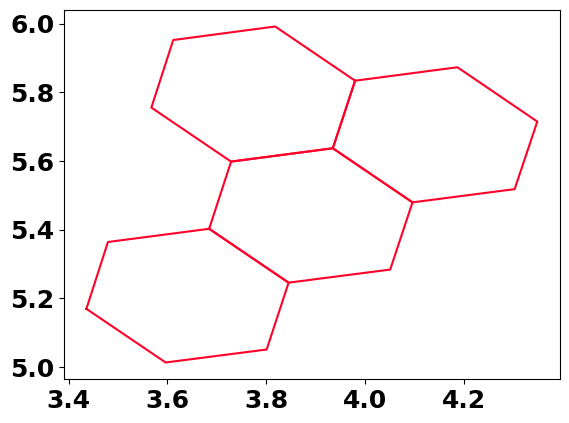

In [49]:
i=171
cluster=clusters[i]
cluster_color = list(scalarMapList[0][0:3])
if type(cluster) == Polygon:
    polyg=np.asarray(cluster.exterior.xy[::-1])
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    plt.plot(*polyg,color=cluster_color)
else:
    for geom in cluster.geoms:
        # Assert as numpy array from tuple
        polyg=np.asarray(geom.exterior.xy[::-1])
        # Fix: If the boundary crosses the 180/-180 meridian,
        #      extend the positive bound into <-180 longitude space
        #      (plotting doesn't appear to care here, otherwise it
        #       forces polygon to span the entire plot)
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        plt.plot(*polyg,color=cluster_color)
#plt.xlim((-180.,180.))
plt.show()

In [50]:
np.random.seed(90210)

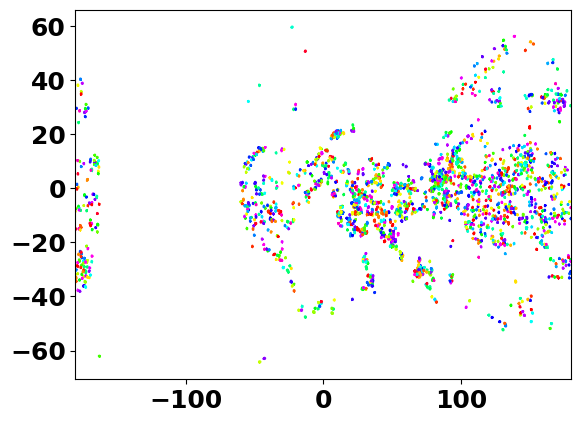

In [51]:
for i in range(n_clusters):
    cluster=clusters[i]
    r=np.random.randint(0,32)
    cluster_color = list(scalarMapList[r][0:3])
    if type(cluster) == Polygon:
        polyg=np.asarray(cluster.exterior.xy[::-1])
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        plt.plot(*polyg,color=cluster_color)
    else:
        for geom in cluster.geoms:
            # Assert as numpy array from tuple
            polyg=np.asarray(geom.exterior.xy[::-1])
            # Fix: If the boundary crosses the 180/-180 meridian,
            #      extend the positive bound into <-180 longitude space
            #      (plotting doesn't appear to care here, otherwise it
            #       forces polygon to span the entire plot)
            if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
                fix=np.where(polyg[0]>0.)
                polyg[0][fix]=polyg[0][fix]-360.
            # Reassert as tuple and plot
            polyg=tuple(polyg.tolist())
            plt.plot(*polyg,color=cluster_color)
#plt.legend(['cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6','cluster 7','cluster 8','cluster 9','cluster 10'])
plt.xlim((-180.,180.))
plt.show()

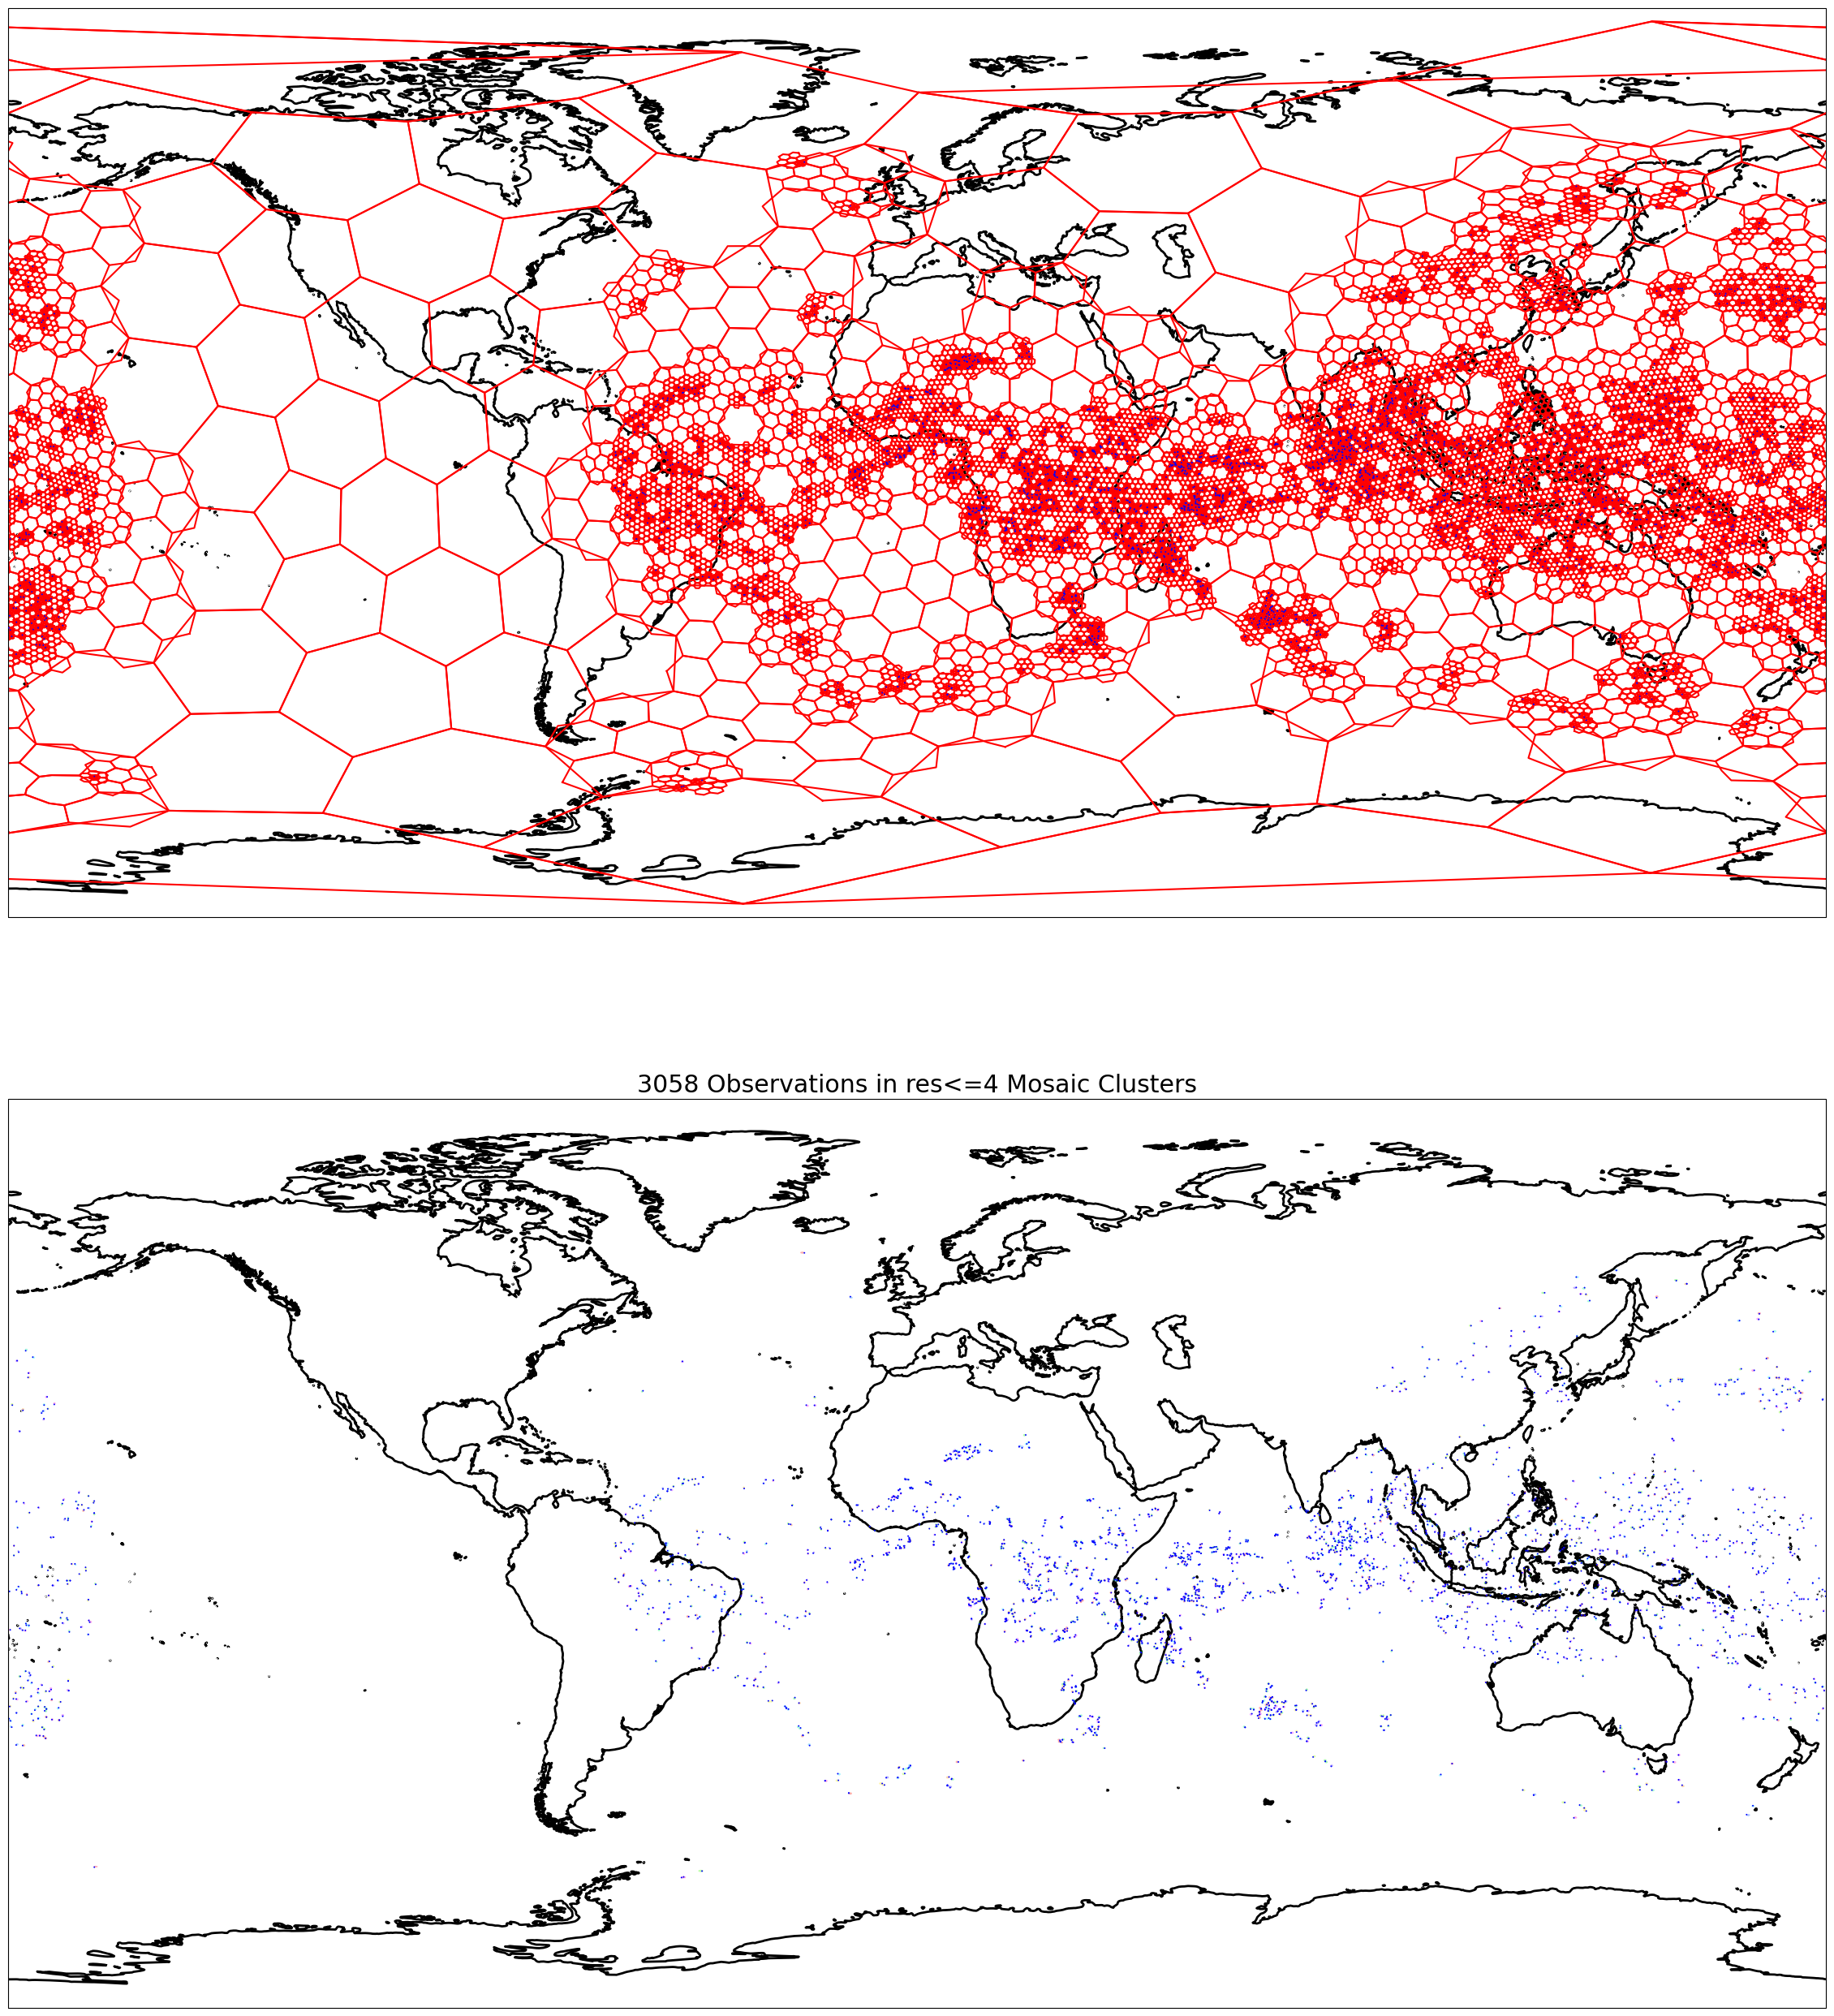

In [52]:
fig,(ax1,ax2)=plt.subplots( #.......................................................................... Figure handle with figure size
                   nrows=2,
                   ncols=1,
                   subplot_kw={'projection': proj},
                   figsize=(30,32)
                   )

ax1.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for geom in h3MosaicMultiPoly.geoms:
    # Assert as numpy array from tuple
    polyg=np.asarray(geom.exterior.xy[::-1])
    # Fix: If the boundary crosses the 180/-180 meridian,
    #      extend the positive bound into <-180 longitude space
    #      (plotting doesn't appear to care here, otherwise it
    #       forces polygon to span the entire plot)
    if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
        fix=np.where(polyg[0]>0.)
        polyg[0][fix]=polyg[0][fix]-360.
    # Reassert as tuple and plot
    polyg=tuple(polyg.tolist())
    ax1.plot(*polyg,color='red',transform=proj,zorder=2)
# Plot obs data on top
sca=ax1.scatter(
           ob_lon[idx],
           ob_lat[idx],
           s=2,
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           zorder=3
          )

ax2.coastlines(resolution='50m',linewidth=2,color='black',zorder=1)
for i in range(n_clusters):
    cluster=clusters[i]
    r=np.random.randint(0,32)
    cluster_color = list(scalarMapList[r][0:3])
    if type(cluster) == Polygon:
        polyg=np.asarray(cluster.exterior.xy[::-1])
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        ax2.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')
    else:
        for geom in cluster.geoms:
            # Assert as numpy array from tuple
            polyg=np.asarray(geom.exterior.xy[::-1])
            # Fix: If the boundary crosses the 180/-180 meridian,
            #      extend the positive bound into <-180 longitude space
            #      (plotting doesn't appear to care here, otherwise it
            #       forces polygon to span the entire plot)
            if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
                fix=np.where(polyg[0]>0.)
                polyg[0][fix]=polyg[0][fix]-360.
            # Reassert as tuple and plot
            polyg=tuple(polyg.tolist())
            ax2.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')
# Plot obs data on top
sca=ax2.scatter(
           ob_lon[idx],
           ob_lat[idx],
           color='blue',
           transform=ccrs.PlateCarree(),
           edgecolor='none',
           s=2,
           zorder=2
          )
ax2.set_global()
ax2.set_title('{:d} Observations in res<={:d} Mosaic Clusters'.format(np.size(idx),res))
plt.show()

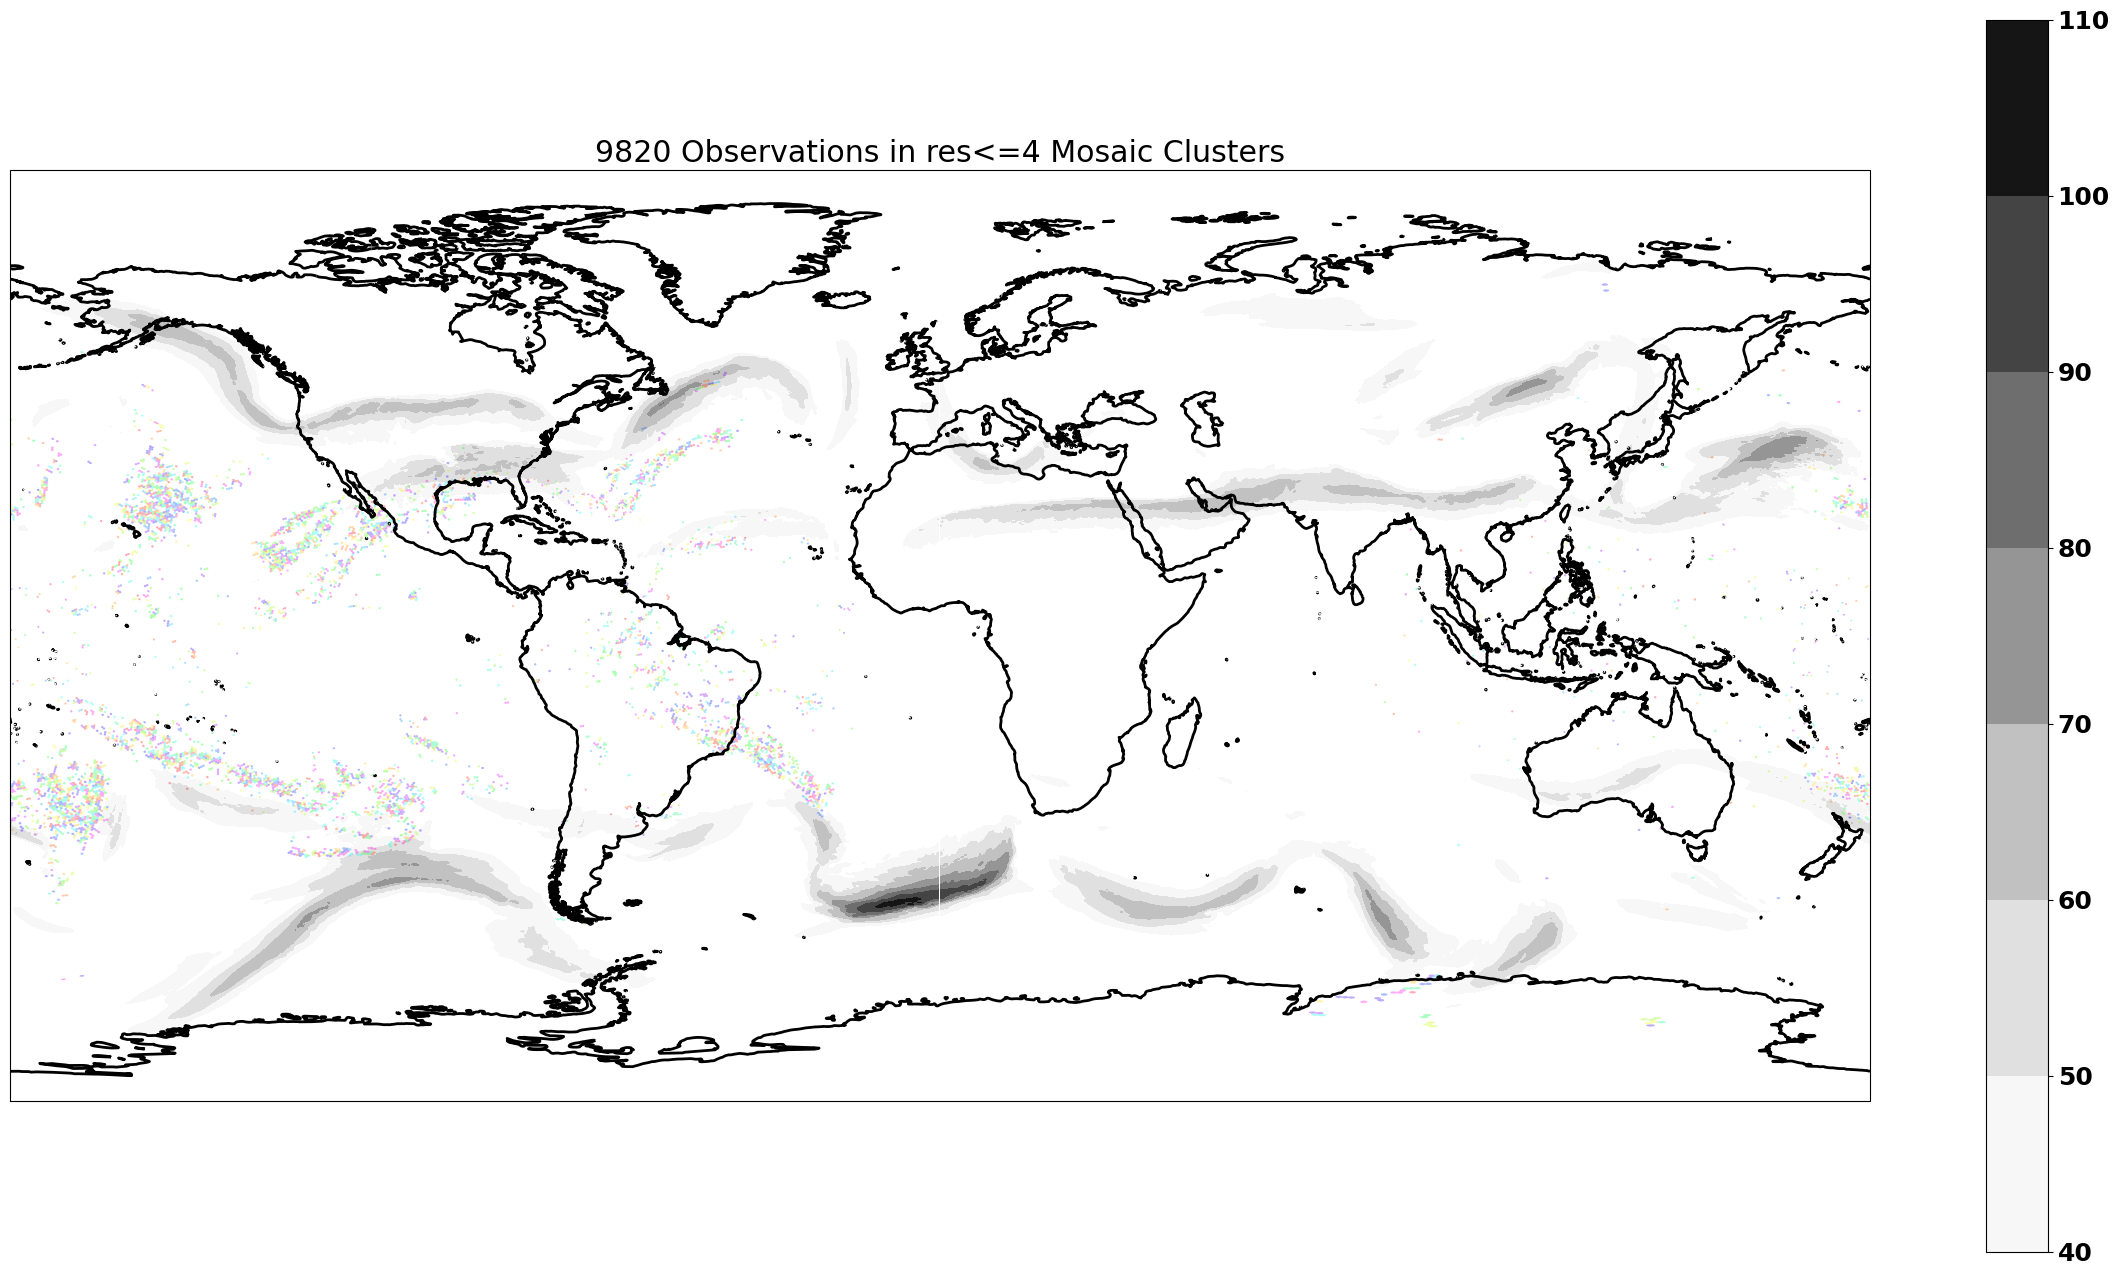

In [44]:
# Plot clusters over wind speed, do we see any relationship?
grib_spd=np.sqrt(grib_uwd**2.+grib_vwd**2.)
smin=40.
smax=110.
clevs=np.arange(smin,smax+0.1,10.)
fig,ax1=plt.subplots( #.......................................................................... Figure handle with figure size
                   nrows=1,
                   ncols=1,
                   subplot_kw={'projection': proj},
                   figsize=(30,16)
                   )
ax1.coastlines(resolution='50m',linewidth=2,color='black',zorder=2)
shd=ax1.contourf(grib_lon,grib_lat,grib_spd,clevs,vmin=smin,vmax=smax,cmap='Greys',zorder=1)
for i in range(n_clusters):
    cluster=clusters[i]
    r=np.random.randint(0,32)
    cluster_color = list(scalarMapList[r][0:3])
    if type(cluster) == Polygon:
        polyg=np.asarray(cluster.exterior.xy[::-1])
        if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
            fix=np.where(polyg[0]>0.)
            polyg[0][fix]=polyg[0][fix]-360.
        # Reassert as tuple and plot
        polyg=tuple(polyg.tolist())
        ax1.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')
    else:
        for geom in cluster.geoms:
            # Assert as numpy array from tuple
            polyg=np.asarray(geom.exterior.xy[::-1])
            # Fix: If the boundary crosses the 180/-180 meridian,
            #      extend the positive bound into <-180 longitude space
            #      (plotting doesn't appear to care here, otherwise it
            #       forces polygon to span the entire plot)
            if np.abs(np.min(polyg[0])-np.max(polyg[0]))>180.:
                fix=np.where(polyg[0]>0.)
                polyg[0][fix]=polyg[0][fix]-360.
            # Reassert as tuple and plot
            polyg=tuple(polyg.tolist())
            ax1.fill(*polyg,color=cluster_color,alpha=0.33,edgecolor='none')

ax1.set_global()
ax1.set_title('{:d} Observations in res<={:d} Mosaic Clusters'.format(np.size(idx),res))
plt.colorbar(mappable=shd)
plt.show()

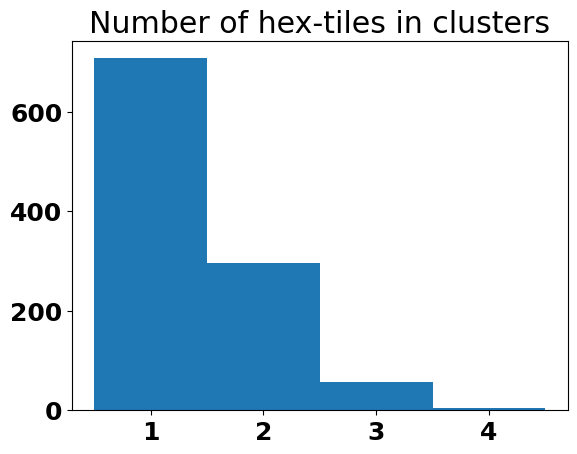

In [160]:
plt.hist(clusmems,np.arange(0.5,max(clusmems)+0.6,1.))
plt.title('Number of hex-tiles in clusters')
plt.show()

In [53]:
# Define the number of obs in a cluster
nobs_clusters=[]
for i in np.sort(cellframe['cluster'].unique()):
    # find all cells in cluster
    cells=cellframe.loc[cellframe['cluster']==i,'h3_cell']
    # start counter at zero
    no=0
    for cell in cells:
        # the code gets a little tricky here only because a .loc will return a pandas
        # series with the index values unchanged from the original dataframe, so the
        # data sits on some intermediate index value rather than zero. We know that there
        # will only be one entry, so we can search for the entry's index-value and then
        # extract the 'nobs' value at that index to get the data:
        # no = no + {single-line series from cellframe containing 'nobs' value}[{index value of single-line series}]
        no = no + cellframe.loc[cellframe['h3_cell']==cell,'nobs'][cellframe.loc[cellframe['h3_cell']==cell,'nobs'].index[0]]
    nobs_clusters.append(no)
nobs_clusters = np.asarray(nobs_clusters).squeeze()

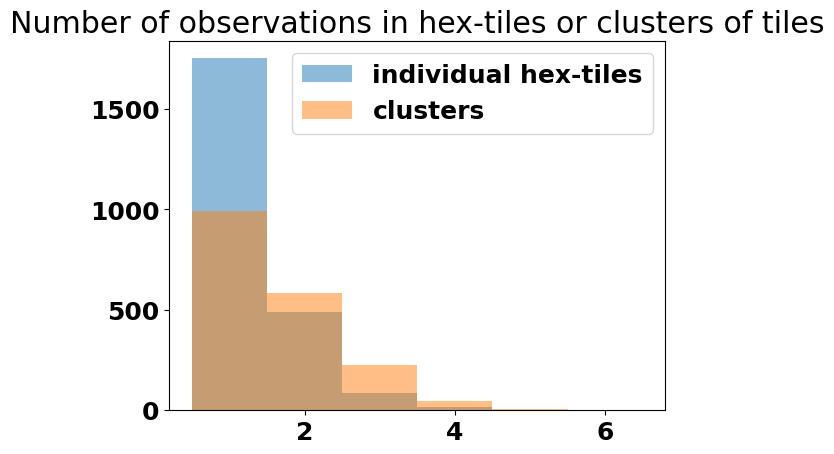

In [54]:
plt.hist(cellframe['nobs'].values,np.arange(0.5,max(cellframe['nobs'].values)+0.6,1.),alpha=0.5)
plt.hist(nobs_clusters,np.arange(0.5,max(nobs_clusters)+0.6,1.),alpha=0.5)
plt.legend(['individual hex-tiles','clusters'])
plt.title('Number of observations in hex-tiles or clusters of tiles')
plt.show()